In [ ]:
import ref_index as RF
from os.path import exists
from numba import jit
import matplotlib.pylab as plt
from scipy.interpolate import UnivariateSpline
from hapi import *
import requests as R
import numpy as np
from scipy.interpolate import CubicSpline, RectBivariateSpline
%matplotlib widget
#


@jit(nopython=True)
def gauss(x, fwhm):
    sigma = fwhm/2./np.sqrt(2*np.log(2.))
    return (np.exp(-(x*x/2/sigma/sigma))/sigma/np.sqrt(2*np.pi))


Kb = 1.380649e-23  # J/K Boltzmans constant
h = 6.626176e-34  # Plancks constant
AMU = 1.6603145e-27
C = 299792458.  # m/s. Speed of light in vacuo


In [ ]:
print("Before, figure default size is: ", plt.rcParams["figure.figsize"])
plt.rcParams["figure.figsize"] = (7, 5)
print("After, figure default size is: ", plt.rcParams["figure.figsize"])


In [ ]:
db_begin('Abanddata')
if not exists('./Abanddata/oxygen2.header'):

    fetch_by_ids('oxygen', [36], 1/776e-7, 1/749e-7)
c2 = 1.4387770  # CM K


In [ ]:
url = "http://129.16.35.2:8080/msis/2019-02-02T12:00:00/70/130/150"
#url = "http://83.252.31.240:59059/msis/2019-06-20T12:00:00/80/130/150"
url = "http://129.16.35.2:8080/msis/2019-12-02T12:00:00/0/130/150"
url = "http://129.16.35.2:8080/msis/2019-03-14T12:00:00/0/130/150" # update for Feb


atm = R.get(url).json()
N = np.array(atm['n2'])+np.array(atm['o2'])+np.array(atm['o'])
pres = N*Kb*atm['T']
atm['p'] = pres
z = np.array(atm['z'])
o2 = np.array(atm['o2'])/1e6  # to cm-3
T = atm['T']


In [ ]:
select('oxygen', ParameterNames=('nu', 'sw', 'local_iso_id', 'a', 'elower', 'gp', 'gpp'),
       Conditions=('==', 'global_upper_quanta', ('STR', ('       b      0'))),
       DestinationTableName='tmp')
nu, sw, iso, a, elow, gp, gpp = np.array(getColumns(
    'tmp', ['nu', 'sw', 'local_iso_id', 'a', 'elower', 'gp', 'gpp']))

for i in range(a.shape[0]):
    a[i] *= abundance(7, iso[i])
    sw[i] *= abundance(7, iso[i])
eup = elow+nu
1e8/min(nu), 1e8/max(nu), min(nu), max(nu)


In [ ]:
plt.figure()
plt.plot(T[60:110],z[60:110])

In [ ]:
plt.figure()
plt.plot(nu, sw, '.')


In [8]:
Dfwhm = nu*2/C * np.sqrt(2*Kb*298.*np.log(2)/32/AMU)
grid = np.arange(12950, 13200, 0.002)
grid = np.arange(12800, 13400, 0.002)
sigma = np.zeros([len(z), len(grid)])
emission = np.zeros([len(z), len(grid)])
for layer in range(len(z)):
    print('layer number = {}'.format(layer))
    Sjlayer = sw*298/T[layer]*np.exp(1.439*elow*(T[layer]-298)/298/T[layer])
    intens = gp*a*np.exp(-c2*eup/T[layer])*nu*nu
    intens /= intens.sum()
    DfwhmLayer = Dfwhm*np.sqrt(T[layer]/298.)
    for i in range(len(nu)):
        sigma[layer, :] += (Sjlayer[i]*gauss(grid-nu[i], DfwhmLayer[i]))
        emission[layer, :] += (intens[i]*gauss(grid-nu[i], DfwhmLayer[i]))


layer number = 12
layer number = 13
layer number = 14
layer number = 15
layer number = 16
layer number = 17
layer number = 18
layer number = 19
layer number = 20
layer number = 21
layer number = 22
layer number = 23
layer number = 24
layer number = 25
layer number = 26
layer number = 27
layer number = 28
layer number = 29
layer number = 30
layer number = 31
layer number = 32
layer number = 33
layer number = 34
layer number = 35
layer number = 36
layer number = 37
layer number = 38
layer number = 39
layer number = 40
layer number = 41
layer number = 42
layer number = 43
layer number = 44
layer number = 45
layer number = 46
layer number = 47
layer number = 48
layer number = 49
layer number = 50
layer number = 51
layer number = 52
layer number = 53
layer number = 54
layer number = 55
layer number = 56
layer number = 57
layer number = 58
layer number = 59
layer number = 60
layer number = 61
layer number = 62
layer number = 63
layer number = 64
layer number = 65
layer number = 66
layer numb

In [9]:
#np.save('o2AbandsigmaDec0N0-150', sigma)
#np.save('o2AbandemissionDec0N0-150', emission)

np.save('o2AbandsigmaFeb0N0-150', sigma)
np.save('o2AbandemissionFeb0N0-150', emission)

print('saved!')


saved!


In [10]:
#sigma = np.load('o2AbandsigmaDec0N0-150.npy')
#emission = np.load('o2AbandemissionDec0N0-150.npy')

sigma = np.load('o2AbandsigmaFeb0N0-150.npy')
emission = np.load('o2AbandemissionFeb0N0-150.npy')

print('loaded!')


loaded!


In [11]:
@jit(nopython=True, cache=True)
def path_z(z_top, z_t, sol_zen, nsteps):
    Re = 6375.  # km
    sol_zen /= 180/np.pi
    B = np.arcsin((Re+z_t) * np.sin(np.pi-sol_zen)/(Re+z_top))
    S_top = np.sin(sol_zen-B)*(Re+z_top)/np.sin(np.pi-sol_zen)

    Ret2 = (Re + z_t)**2
    step = S_top/nsteps
    S_top_half = S_top - step/2
    z_step = [np.sqrt(Ret2 + (S_top_half - i*step)**2 - 2*(Re + z_t) *
                      (S_top_half - i*step)*np.cos(np.pi-sol_zen))-Re for i in range(nsteps)]
    return (z_step, step)


/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_

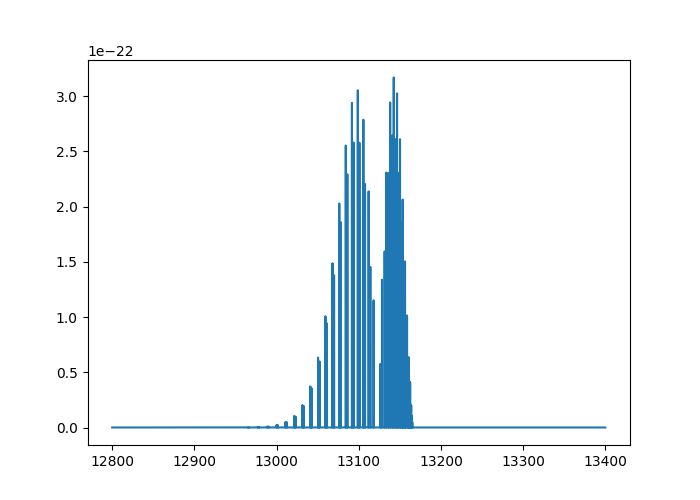

In [12]:
plt.figure()
#plt.plot(grid[45500:46500],sigma[50, 45500:46500].T,grid[45500:46500],sigma2[50, 45500:46500].T)
plt.plot(grid,sigma[50,:])

In [13]:
deltaz = np.diff(z).mean()
for i in range(emission.shape[0]):
    emission[i, :] /= emission[i, :].sum()
emissum = emission[-1, :].sum()
print(emissum)
no_steps = 100
tanheights = np.arange(30, 120, 5)
taus = np.zeros((sigma.shape[1], 2*no_steps-1, len(tanheights)))
i = 0
path_steps = []
factor = []

for tanz in tanheights:
    z_paths, path_step = path_z(z[-1], tanz, 90.0, no_steps)
    path_steps.append(path_step)
    z_paths.extend(z_paths[-2::-1])
    zi = np.floor((np.array(z_paths)-z[0])/deltaz).astype(int)
    #emissum = emission[zi, :].sum()/no_steps/2
    tau = (sigma[zi, :].T*(np.exp(np.interp(z_paths, z, np.log(o2))))
           ).cumsum(axis=1)*path_step * 1e5
    taus[:, :, i] = tau
    factor.append(((np.exp(-taus[:, :, i])*emission[zi, :].T)).sum(0)/emissum)
    i += 1


1.0


/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_

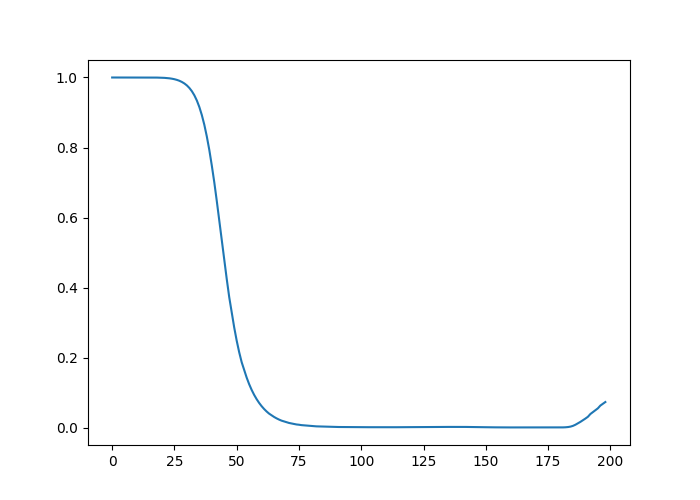

In [14]:
plt.figure()
plt.plot(factor[0])

In [15]:
i = 2
testtest=(filters @ (np.exp(-taus[:, :, i])*emission[zi, :].T))/emissum


plt.figure()


plt.plot(testtest.T)

NameError: name 'filters' is not defined

In [16]:
IR1=np.loadtxt('F-N-IR1-ABandCenter_transmission_air_6degr.dat',skiprows=1,unpack=True)
IR2=np.loadtxt('F-N-IR2-ABandTotal_air_6degr.dat',skiprows=1,unpack=True)
#IR3=np.loadtxt('MATS-analysis/Donal/retrievals/Datafiles/F-N-IR3-BgShort_transmission_air_6degr.dat',skiprows=1,unpack=True)
#IR4=np.loadtxt('MATS-analysis/Donal/retrievals/Datafiles/F-N-IR4-BgLong_transmission_air_6degr.dat',skiprows=1,unpack=True)
#convert from wavelength in air to wavelength in vacupe

IR1[0,:]=RF.air2vac(IR1[0,:])
IR2[0,:]=RF.air2vac(IR2[0,:])
IR1[1,:]/=100
IR2[1,:]/=100
#IR3[1,:]/=100
#IR4[1,:]/=100
filter1=np.interp(grid, 1e7/IR1[0,-1::-1],IR1[1,-1::-1],left=0,right=0)
filter2=np.interp(grid, 1e7/IR2[0,-1::-1],IR2[1,-1::-1],left=0,right=0)
filters=np.vstack([filter1,filter2])

# filters ok

In [17]:
deltaz = np.diff(z).mean()
for i in range(emission.shape[0]):
    emission[i, :] /= emission[i, :].sum() # normalise (full band) emissions
emissum = emission[-1, :].sum() 
print(emissum) # check that = one
no_steps = 100
tanheights = np.arange(30, 120, 5)
taus = np.zeros((sigma.shape[1], 2*no_steps-1, len(tanheights))) # 'allocate'
i = 0
path_steps = []
factor = []
logo2=np.log(o2)
for tanz in tanheights:
    z_paths, path_step = path_z(z[-1], tanz, 90.0, no_steps)
    path_steps.append(path_step)
    z_paths.extend(z_paths[-2::-1])
    zi = np.floor((np.array(z_paths)-z[0])/deltaz).astype(int)
    emissum = filters @ emission[zi, :].T # generate filtered radiances (sum wavelength)
    tau = (sigma[zi, :].T*(np.exp(np.interp(z_paths, z, logo2)))
           ).cumsum(axis=1)*path_step * 1e5
    taus[:, :, i] = tau
    #emissions=np.array([emission[zi,:].T/emissum[0,:],emission[zi,:].T/emissum[1,:]]) 
    emissions=np.array([emission[zi,:].T,emission[zi,:].T]) 
    
    factor.append((filters@(np.exp(-taus[:, :, i])*emissions))) 
    i += 1



1.0


In [ ]:
    #factor.append((filters@(np.exp(-taus[:, :, i])*emission[zi, :].T))/emissum)

In [ ]:
plt.figure()
plt.plot((emission[zi,:].T/emissum[0,:]).sum(axis=0))


In [ ]:
filters@np.exp(-taus[:, :, 16])

In [ ]:
i = 0
(filters@(np.exp(-taus[:, :, i])*emission[zi, :].T)/emissum).shape

In [ ]:
#plt.figure()


factors= np.array(factor)
factors.shape

#emissions.shape

In [ ]:
plt.figure()
plt.plot(factors[:,0,:])

In [ ]:
factors.shape

Text(0.5, 1.0, 'Absorption and IR1/IR2')

/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_

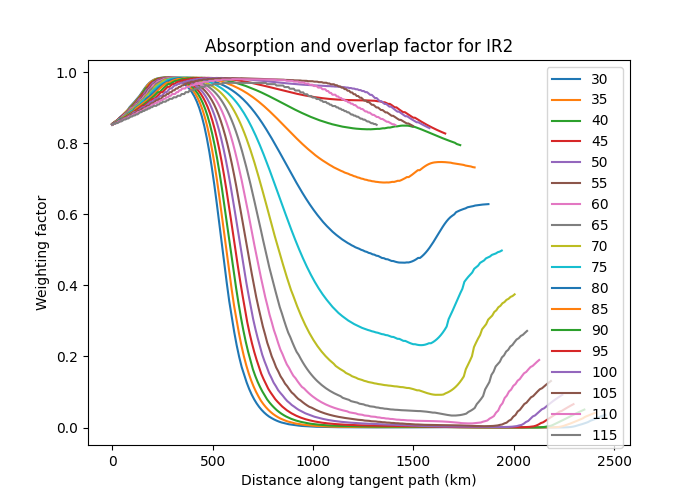

/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_

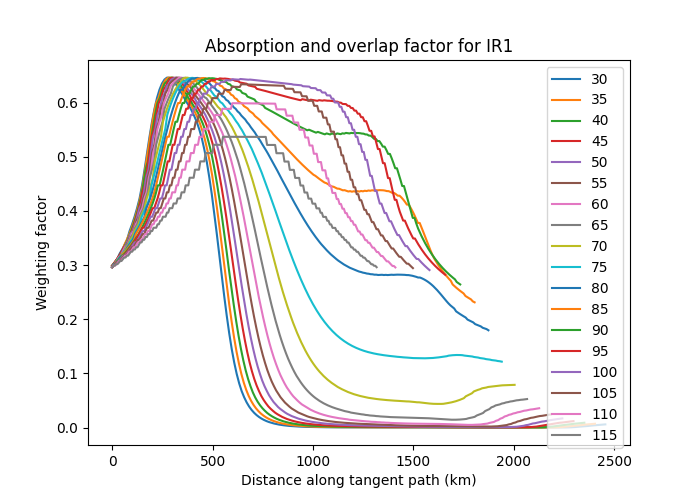

/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_

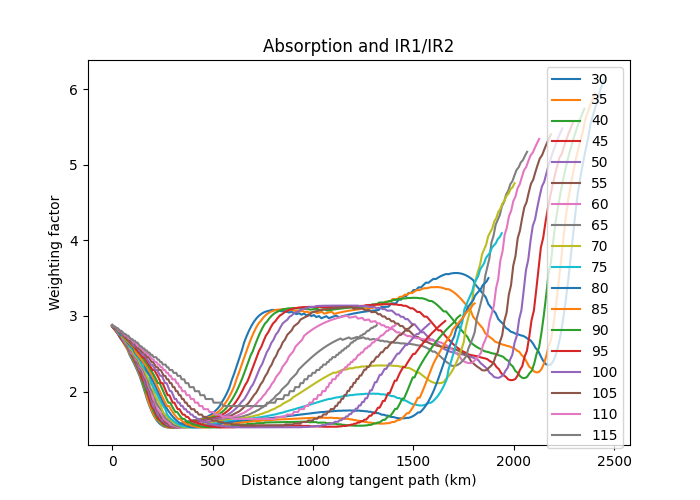

In [28]:
factors= np.array(factor)
plt.figure(figsize=(7, 5))
#plt.plot(np.array([np.arange(2*no_steps-1) *
#         p for p in path_steps]).T, np.array(factors[:,0,1,:]).T)

plt.plot(np.array([np.arange(2*no_steps-1) *
         p for p in path_steps]).T, np.array(factors[:,0,1,:]).T)

plt.legend(tanheights)
plt.xlabel('Distance along tangent path (km)')
plt.ylabel('Weighting factor')
plt.title('Absorption and overlap factor for IR2')
plt.figure(figsize=(7, 5))
plt.plot(np.array([np.arange(2*no_steps-1) *
         p for p in path_steps]).T, np.array(factors[:,1,0,:]).T)
plt.legend(tanheights)
plt.xlabel('Distance along tangent path (km)')
plt.ylabel('Weighting factor')
plt.title('Absorption and overlap factor for IR1')

plt.figure(figsize=(7, 5))
plt.plot(np.array([np.arange(2*no_steps-1) *
         p for p in path_steps]).T,
         (np.array(factors[:,0,1,:]).T)/(np.array(factors[:,1,0,:]).T))
plt.legend(tanheights)
plt.xlabel('Distance along tangent path (km)')
plt.ylabel('Weighting factor')
plt.title('Absorption and IR1/IR2')




/tmp/ipykernel_2281342/1937330281.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_

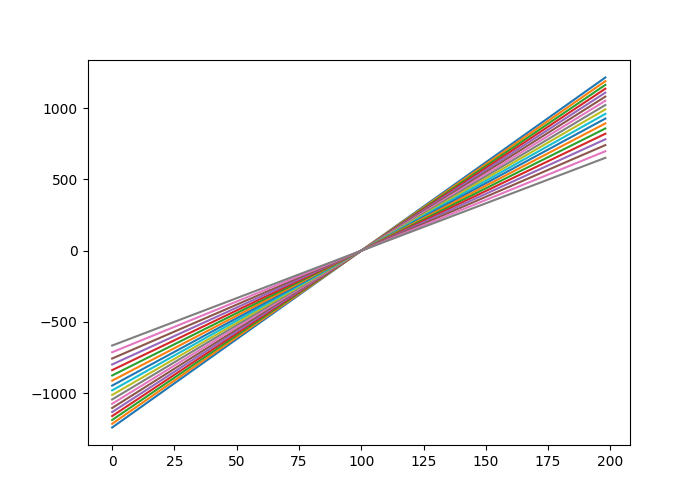

In [31]:
distances = np.array([np.arange(2*no_steps-1) *
                      p for p in path_steps]).T
distances -= distances[100, :]
plt.figure()
plt.plot(distances-distances[100, :])
splinedcorr = [] 
for i in range(len(tanheights)): 
    #splinedcorr.append(CubicSpline(distances[:, i], np.log(factors[i,1,0,:]))) # IR1
    splinedcorr.append(CubicSpline(distances[:, i], np.log(factors[i,0,1,:]))) # IR2
    #splinedcorr.append(CubicSpline(distances[:, i], np.log(factors[i,0,0,:]/factors[i,1,1,:]))) # fraction

In [ ]:
factors.T.shape

(0.0, 10.0)

/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_

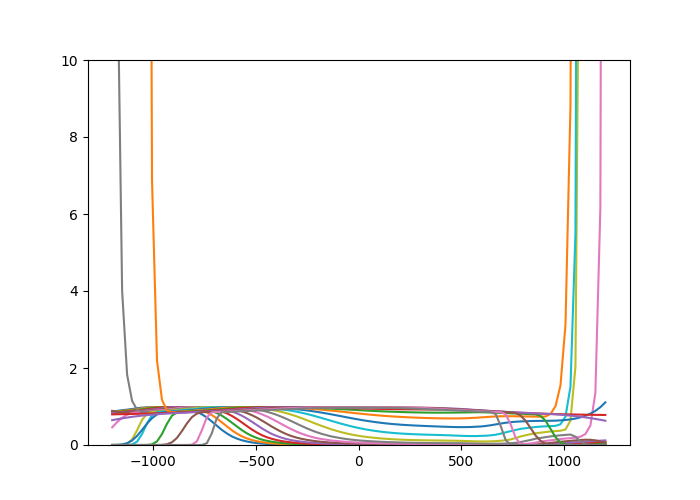

In [32]:
testdist = np.linspace(-1200, 1200, 100)
plt.figure()
corrfactor = np.zeros([len(testdist), len(tanheights)])
for i in range(len(tanheights)):
    corrfactor[:, i] = (splinedcorr[i](testdist))
plt.plot(testdist, np.exp(corrfactor))
plt.ylim([0, 10])


(0.0, 1.0)

/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_

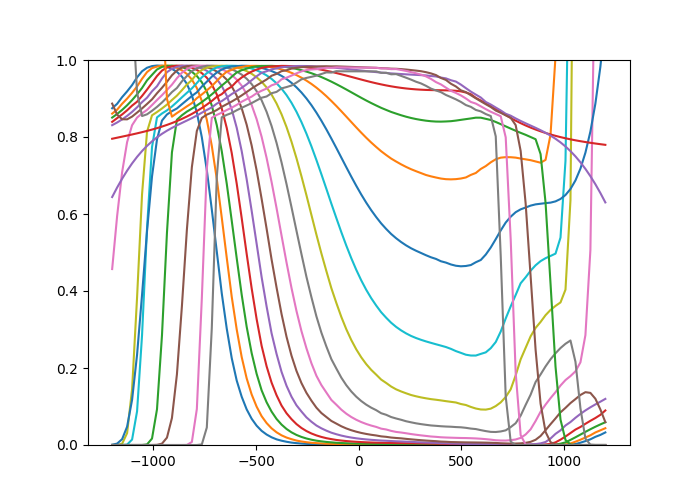

In [33]:
spline2dlogfactor = RectBivariateSpline(tanheights, testdist, corrfactor.T)
plt.figure()
plt.plot(testdist, np.exp(spline2dlogfactor(tanheights, testdist)).T)
plt.ylim([0, 1])


In [34]:
#np.save('splinedlogfactorsIR1IR2.npy', [tanheights, splinedcorr])
#np.save('splined2dlogfactorsIR1IR2.npy', spline2dlogfactor)

np.save('splinedlogfactorsIR2_feb.npy', [tanheights, splinedcorr])
np.save('splined2dlogfactorsIR2_feb.npy', spline2dlogfactor)


In [ ]:
tanz = 30
no_steps = 300
z_paths, path_step = path_z(z[-1], tanz, 90.0, no_steps)
print('Path step = ', path_step)
z_paths.extend(z_paths[-2::-1])
zi = np.floor((np.array(z_paths)-z[0])/deltaz).astype(int)
tau = (sigma[zi, :].T*(np.exp(np.interp(z_paths, z, np.log(o2))))
       ).cumsum(axis=1)*path_step * 1e5


In [ ]:
plt.figure()
plt.plot(path_step*np.arange(2*no_steps-1),
         (np.exp(-tau)*emission[zi, :].T).sum(0)/emissum)
plt.xlabel('Distance along tangent path (km)')
plt.ylabel('Weighting factor')
plt.legend(tanheights)


In [ ]:
onefilter=np.ones([filters.shape[1]])
plt.figure()
#plt.plot(np.exp(-taus[:, -1, :]).mean(axis=0), tanheights)
plt.plot((onefilter @ np.exp(-taus[:, -1, :])).T/onefilter.sum(), tanheights)
plt.plot(((filters @ np.exp(-taus[:, -1, :])).T/filters.sum(axis=1)), tanheights)
plt.xlabel('Transmission')
plt.ylabel('Tangent height (km)')
plt.title(
    'Limb transmission in the {:.1f} - {:.1f} nm region'.format(1e7/grid[-1], 1e7/grid[0]))
plt.ylim([55, 115])
plt.legend(['full','IR1','IR2'])
#plt.xlim([0.85, 1])


In [ ]:
onefilter

In [ ]:
plt.figure()
plt.plot(np.exp(-taus[::10,-1,:]))
#np.exp(-taus[::10,-1,:])
#np.min(taus[:,-1,:])

In [ ]:
filters.shape

In [ ]:
taus.shape


In [ ]:
1/0.005


In [ ]:
taus = []


In [ ]:
np.array(factor).shape


In [ ]:
np.array([np.arange(2*no_steps-1)*p for p in path_steps]).shape


In [ ]:
Dfwhm = nu*2/C * np.sqrt(2*Kb*298.*np.log(2)/32/AMU)
grid = np.arange(12800, 13400, 0.002)
sigma = np.zeros([len(z), len(grid)])
for i in range(z.shape[0]):
    htabs = absorptionCoefficient_Voigt(SourceTables='tmp', Environment={
                                        "p": pres[i]/101300, "T": T[i]}, OmegaGrid=grid)
    sigma[i, :] = htabs[1]


In [ ]:
plt.figure()
plt.plot(grid, htabs[1], grid, sigma[1])


In [ ]:
select('oxygen',
       Conditions=('==', 'global_upper_quanta', ('STR', ('       b      0'))),
       DestinationTableName='tmp')
nu, sw, gamma, nair, iso, a, elow, gp, gpp = np.array(getColumns(
    'tmp', ['nu', 'sw', 'gamma_air', 'n_air', 'local_iso_id', 'a', 'elower', 'gp', 'gpp']))

for i in range(a.shape[0]):
    a[i] *= abundance(7, iso[i])
    sw[i] *= abundance(7, iso[i])
eup = elow+nu
1e7/min(nu), 1e7/max(nu), min(nu), max(nu)


In [ ]:
Dfwhm = nu*2/C * np.sqrt(2*Kb*298.*np.log(2)/32/AMU)
grid = np.arange(12950, 13200, 0.002)
grid = np.arange(12800, 13400, 0.002)
sigma2 = np.zeros([len(z), len(grid)])
emission2 = np.zeros([len(z), len(grid)])
for layer in range(len(z)):
    print('layer number = {}'.format(layer))
    Sjlayer = sw*298/T[layer]*np.exp(1.439*elow*(T[layer]-298)/298/T[layer])
    intens = gp*a*np.exp(-c2*eup/T[layer])*nu*nu
    intens /= intens.sum()
    DfwhmLayer = Dfwhm*np.sqrt(T[layer]/298.)
    gammaLayer = gamma*pres[layer]/101300*(298/T[layer])**nair
    print('doppler {} Pressure {}'.format(DfwhmLayer[10]/2, gammaLayer[10]))
    winglimit = 1000
    for i in range(len(nu)):
        wing = np.max((winglimit*gammaLayer[i], winglimit*DfwhmLayer[i]/2))
        bl = bisect(grid, nu[i]-wing)
        bu = bisect(grid, nu[i]+wing)
        sigma2[layer, bl:bu] += (Sjlayer[i]*PROFILE_VOIGT(nu[i],
                                 DfwhmLayer[i]/2, gammaLayer[i], 0, grid[bl:bu]))
        emission2[layer, bl:bu] += (intens[i]*PROFILE_VOIGT(nu[i],
                                    DfwhmLayer[i]/2, gammaLayer[i], 0, grid[bl:bu]))


In [ ]:
nu[0], nu[-1]


In [ ]:
np.save('o2A-bandVoightsigmaDec0N0-150', sigma2)
np.save('o2A-bandVoightemissionDec0N0-150', emission2)

In [ ]:
layer = 1
pres[layer]


#### 

###### 

In [ ]:

plt.figure()
# plt.plot(grid2,emission2[140],'.',grid1,emission[140])
plt.plot(grid, sigma2[1], grid, sigma2[1])


In [ ]:
np.save('o2A-bandVoightsigma0-150', sigma2)
np.save('o2A-bandVoightemission0-150', emission2)


In [ ]:
Dfwhm = nu*2/C * np.sqrt(2*Kb*298.*np.log(2)/32/AMU)
grid = np.arange(12800, 13400, 0.002)
t1 = PROFILE_VOIGT(nu[0], Dfwhm[0]/2, gamma[0], 0, grid)
t2 = gauss(grid-nu[0], Dfwhm[100])


In [ ]:
plt.figure()
plt.plot(grid, t1, grid, t2)
bl = bisect(grid, nu[0]-0.21)
bu = bisect(grid, nu[0]+0.2)
plt.xlim([grid[bl], grid[bu]])


In [ ]:
url = "http://83.252.31.240:59059/msis/2019-02-02T12:00:00/55/130/150"
a = R.get(url).json()
N = np.array(a['n2'])+np.array(a['o2'])+np.array(a['o'])
pres = N*Kb*a['T']
a['p'] = pres
z = np.array(a['z'])
o2 = np.array(a['o2'])/1e6  # to cm-3
T = np.array(a['T'])


In [ ]:
a['T'].shape


In [ ]:
plt.figure()
plt.plot(T, z)
plt.show()
